In [77]:
import os
import datetime
from datetime import timedelta
import numpy as np
from funcs import get_parc_sizes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [88]:
def conv_t_delta(in_str):
    
    in_str = in_str.replace('Time Elapsed: ', '').strip()
    
    s = in_str.split(':')
    
    if len(s) == 3:
        return timedelta(hours=int(s[0]), minutes=int(s[1]), seconds=int(s[2]))
    else:
        print(s)
        

def is_binary(target):
    
    if target.endswith('_binary'):
        return True
    
    # Otherwise check exceptions
    binary = ['ksads_back_c_det_susp_p', 'married.bl',
              'accult_phenx_q2_p', 'devhx_5_twin_p',
              'sex_at_birth', 'devhx_6_pregnancy_planned_p',
              'devhx_12a_born_premature_p',
              'ksads_back_c_mh_sa_p']

    return target in binary

def extract(txt):
    
    if 'Validation Scores\n' in txt:

        run_ind = 'Running for:'

        if run_ind in txt[1]:
            run_info = txt[1]
        elif run_ind in txt[2]:
            run_info = txt[2]


        run_info = run_info.replace(run_ind, '').lstrip()
        n_strip = run_info.split('---')
        
        parcel = n_strip[0]
        
        p_type = 'base'
        if parcel.startswith('stacked_'):
            p_type = 'stacked'
        elif parcel.startswith('voted'):
            p_type = 'voted'
        
        try:
            size = parc_sizes[parcel]
        except KeyError:
            return tuple([None] * 5)
            
        model = n_strip[1]
        is_b = is_binary(n_strip[2].rstrip())

        te_ind = 'Time Elapsed: '
        time_elapsed = [conv_t_delta(l) for l in txt if l.startswith(te_ind)]

        full = None
        if len(n_strip) == 4:
            if len(time_elapsed) == 1:
                full = time_elapsed[0] * 5

        else:
            if len(time_elapsed) == 5:
                full = np.sum(time_elapsed)
            
        if full is not None:
            return model, size, is_b, full, p_type
    
    return tuple([None] * 5)

def get_time_df(dr):
    
    files = os.listdir(dr)
    files = [file for file in files if '.out' in file]
    
    timing = pd.DataFrame(columns=['model', 'size', 'is_b', 'n_jobs', 'time', 'p_type'])

    for file in files: 
        full_path = os.path.join(dr, file)

        # Open file
        with open(full_path, 'r') as f:
            txt = f.readlines()

        # Extract
        model, size, is_b, full, p_type = extract(txt)

        # If not done or other error
        if model is None:
            continue

        # Determine how job was run
        if file.startswith('test_'):
            n_jobs = 8
        elif file.startswith('4_'):
            n_jobs = 4

        elif file.startswith('low_') or file.startswith('high_'):
            if '_extra' in file:
                n_jobs = 48
            else:
                n_jobs = 24
        elif file.startswith('long_'):
            n_jobs = 1

        else:
            print('error:', file)

        timing.loc[len(timing)] = [model, size, is_b, n_jobs, full.total_seconds(), p_type]
        
    return timing

In [89]:
parc_sizes = get_parc_sizes()
dr = '/home/sage/BLUE/Parcs_Project/Exp/Job_Logs'
timing = get_time_df(dr)

In [101]:
def get_yticks(up_to=1):
    
    if up_to == 1:
        
        plt.yticks([3600, 18000, 36000, 54000, 72000, 86400],
                   ['1 Hour', '5 Hours', '10 Hours',
                    '15 Hours', '20 Hours', '1 Day'])

    elif up_to == 4:
        
        plt.yticks([3600, 36000, 86400,
                    86400*2, 86400*3, 86400*4],
                    ['1 Hour', '10 Hours', '1 Day', '2 Days',
                     '3 Days', '4 Days'])


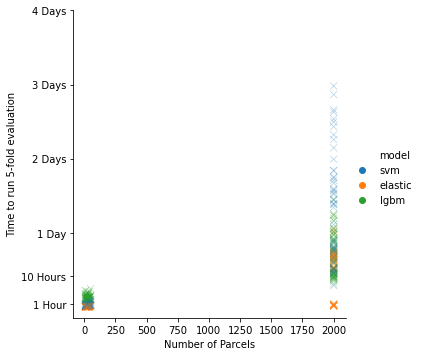

In [102]:
t_df = timing.set_index(['n_jobs']).loc[8]

g = sns.relplot(
    data=t_df, alpha=.3,
    x="size", y="time", hue="model",
    marker="x", s=50,
)

plt.ylabel('Time to run 5-fold evaluation')
get_yticks(up_to=4)
plt.xlabel('Number of Parcels')

plt.show()